In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

In [2]:
train = np.load('/Users/drew/Documents/MathModeling/MathModeling/wave_fitting/data/data_train_25.npz')
test = np.load('/Users/drew/Documents/MathModeling/MathModeling/wave_fitting/data/data_test_7.npz')
train_X, train_t, train_Y = train['X'], train['t'], train['Y']
test_X, test_t, test_Y = test['X'], test['t'], test['Y']
print(train_X.shape, train_t.shape, train_Y.shape, test_X.shape, test_t.shape, test_Y.shape)

(25, 100001) (100001,) (25, 100001) (7, 100001) (100001,) (7, 100001)


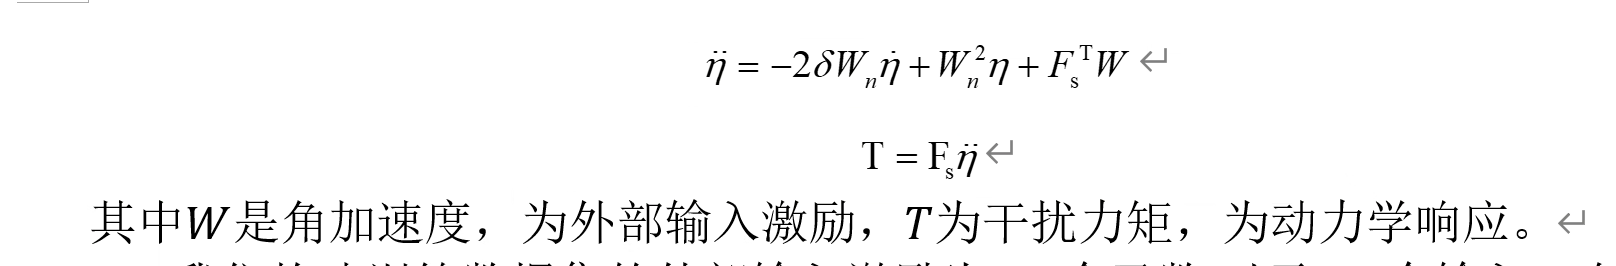

In [3]:
def model(t, y, delta, W_n, F_s, W):
    eta, eta_dot = y
    eta_ddot = -2 * delta * W_n * eta_dot + W_n**2 * eta + F_s * W
    return [eta_dot, eta_ddot]

def residuals(params, t, train_X, train_Y):
    delta, W_n, F_s, W = params
    residuals = []
    for i in range(train_X.shape[0]):
        y0 = [train_X[i, 0], 0]  # 初始条件
        solution = solve_ivp(
            model, 
            (t[0], t[-1]), 
            y0, 
            t_eval=t, 
            args=(delta, W_n, F_s, W)
        )
        residuals.append(solution.y[0] - train_Y[i])
    return np.concatenate(residuals)

# 初始参数猜测
initial_params = [0.5, 1.0, 1.0, 1.0]
# 使用least_squares进行优化
result = least_squares(
    residuals, 
    initial_params, 
    verbose=2, 
    args=(train_t, train_X, train_Y)
)
# 输出优化结果
optimal_params = result.x
print("Optimal Parameters:", optimal_params)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0068e+57                                    3.58e+59    
       1              2         1.5871e+44      3.01e+57       1.80e+00       3.59e+46    
       2              3         1.1626e+24      1.59e+44       3.61e+00       4.83e+26    
       3              4         3.4190e+22      1.13e+24       7.21e+00       8.55e+24    
       4              6         1.2511e+21      3.29e+22       3.61e+00       3.68e+23    
       5              7         3.3257e+19      1.22e+21       7.21e+00       1.47e+22    
       6              9         5.1358e+18      2.81e+19       3.61e+00       2.46e+21    
       7             10         3.9117e+18      1.22e+18       7.21e+00       1.89e+21    
       8             11         4.2442e+16      3.87e+18       1.80e+00       2.14e+19    
       9             12         1.6206e+15      4.08e+16       3.61e+00       9.24e+17    

In [5]:
optimal_params = result.x
delta_opt, W_n_opt, F_s_opt, W_opt = optimal_params

y_hat = []
for i in range(train_X.shape[0]):
    y0 = [train_X[i, 0], 0]  # 初始条件
    solution = solve_ivp(
        model, 
        (train_t[0], train_t[-1]), 
        y0, 
        t_eval=train_t, 
        args=(delta_opt, W_n_opt, F_s_opt, W_opt)
    )
    y_hat.append(solution.y[0])

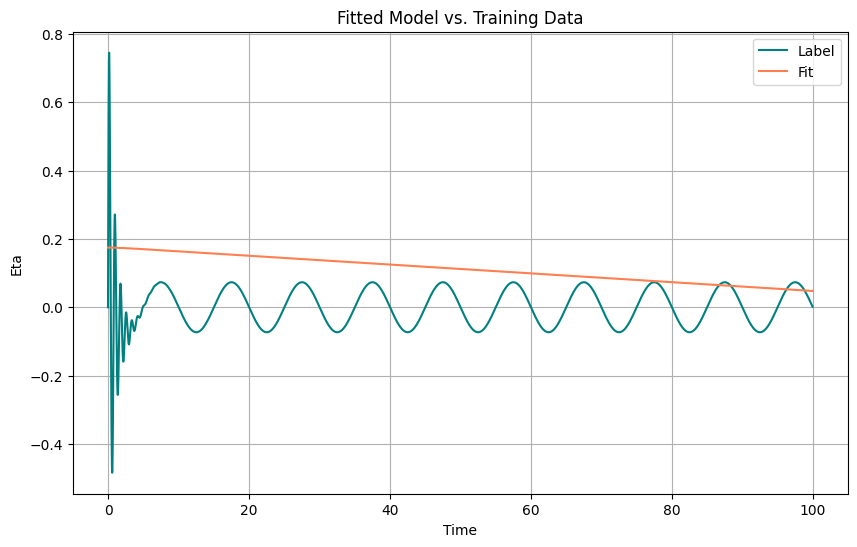

In [10]:
y_hat = np.array(y_hat)
i = 4
plt.figure(figsize=(10, 6))
plt.plot(test_t, test_Y[i], color='teal', label='Label')
plt.plot(test_t, y_hat[i], color='coral', label='Fit')
plt.xlabel('Time')
plt.ylabel('Eta')
plt.title('Fitted Model vs. Training Data')
plt.legend()
plt.grid(True)
plt.show()